### Challenge

You are being tasked with investigating a collection of clients that applied for a loan but were declined. You are to use a
K-means clustering to identify clusters of clients within the collection. Also perform some exploratory data analysis on the data.

In [1]:
#importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', 500)

C:\Users\user\Anaconda2\envs\py35\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#read in the data
data = pd.read_csv('week3_challenge.csv')
data.head()

,Unnamed: 0,createdAt_Month,Reason,application_id,SystemCustomerID,SystemLoanID,income_source,income_verified,next_loan_number,country,DecisionFlag,Product,Income,ID,ApplicationID,__v,CompletedAt,score,demofeatures_debt_to_income_ratio,demofeatures_net_income_band,demofeatures_appweek,demofeatures_payweek,demofeatures_time_at_employer_mths,demofeatures_age_at_application_yrs,demofeatures_device,demofeatures_loan_purpose,demofeatures_time_curr_address,demofeatures_residence_state,demofeatures_bank_name,demofeatures_level_of_education,demofeatures_marital_status,demofeatures_residential_status,demofeatures_employment_status_clients,demofeatures_gender,demofeatures_num_children,demofeatures_num_employers,demofeatures_next_of_kin_relationship,demofeatures_avg_household_exp_pm,demofeatures_num_in_household,demofeatures_facebookid,smsFeatures_minmaxdebit_tot,smsFeatures_mixmaxcredit_tot,smsFeatures_minbal_tot,smsFeatures_pers_sms_snt_flag,smsFeatures_pers_sms_rec_flag,smsFeatures_arrears_flag,smsFeatures_isp_flag,smsFeatures_sattv_flag,smsFeatures_avg_mly_airtimecredit_val,smsFeatures_avg_airtimecredit_tx_val,smsFeatures_tot_airtimecredit_vol,smsFeatures_tot_airtimecredit_val,smsFeatures_avg_mly_uber_val,smsFeatures_avg_uber_tx_val,smsFeatures_tot_uber_vol,smsFeatures_tot_uber_val,smsFeatures_avg_mly_gamble_val,smsFeatures_avg_gamble_tx_val,smsFeatures_tot_gamble_vol,smsFeatures_tot_gamble_val,smsFeatures_loans_prev2mnths,smsFeatures_loan_pmnts,smsFeatures_val_loans,smsFeatures_avg_sal,smsFeatures_debit_credit_ratio,smsFeatures_avg_mly_deb_val,smsFeatures_avg_mly_cred_val,smsFeatures_avg_deb_tx_val,smsFeatures_avg_cred_tx_val,smsFeatures_tot_deb_vol,smsFeatures_tot_deb_val,smsFeatures_tot_cred_vol,smsFeatures_tot_cred_val,smsFeatures_num_mnths_obs,jazzScore,clientKey,loanKey,loanId,contactFeatures_ratio_surnames,contactFeatures_avg_calls_per_day_contacts,contactFeatures_share_of_contacts_called,contactFeatures_days_active_caller_contacts,contactFeatures_days_since_last_call_contacts,contactFeatures_days_since_first_call_contacts,contactFeatures_no_contacts_called,contactFeatures_calls_volume_contacts,contactFeatures_most_called_contact_call_volume,contactFeatures_no_contacts,utcOffset,clientId,createdAt,callFeatures_dur_01_miss,callFeatures_dur_02_miss,callFeatures_dur_03_miss,callFeatures_dur_04_miss,callFeatures_dur_05_miss,callFeatures_dur_06_miss,callFeatures_dur_07_miss,callFeatures_dur_08_miss,callFeatures_dur_09_miss,callFeatures_dur_10_miss,callFeatures_dur_11_miss,callFeatures_dur_12_miss,callFeatures_dur_13_miss,callFeatures_dur_14_miss,callFeatures_dur_15_miss,callFeatures_dur_16_miss,callFeatures_dur_17_miss,callFeatures_dur_18_miss,callFeatures_dur_19_miss,callFeatures_dur_20_miss,callFeatures_dur_21_miss,callFeatures_dur_22_miss,callFeatures_dur_23_miss,callFeatures_01_miss,callFeatures_02_miss,callFeatures_03_miss,callFeatures_04_miss,callFeatures_05_miss,callFeatures_06_miss,callFeatures_07_miss,callFeatures_08_miss,callFeatures_09_miss,callFeatures_10_miss,callFeatures_11_miss,callFeatures_12_miss,callFeatures_13_miss,callFeatures_14_miss,callFeatures_15_miss,callFeatures_16_miss,callFeatures_17_miss,callFeatures_18_miss,callFeatures_19_miss,callFeatures_20_miss,callFeatures_21_miss,callFeatures_22_miss,callFeatures_23_miss,callFeatures_dur_01_out,callFeatures_dur_02_out,callFeatures_dur_03_out,callFeatures_dur_04_out,callFeatures_dur_05_out,callFeatures_dur_06_out,callFeatures_dur_07_out,callFeatures_dur_08_out,callFeatures_dur_09_out,callFeatures_dur_10_out,callFeatures_dur_11_out,callFeatures_dur_12_out,callFeatures_dur_13_out,callFeatures_dur_14_out,callFeatures_dur_15_out,callFeatures_dur_16_out,callFeatures_dur_17_out,callFeatures_dur_18_out,callFeatures_dur_19_out,callFeatures_dur_20_out,callFeatures_dur_21_out,callFeatures_dur_22_out,callFeatures_dur_23_out,callFeatures_01_out,callFeatures_02_out,callFeatures_03_out,callFeatures_04_out,callFeatures_05_out,callFeatures_06_out,callFeatures_07_out,callFeatures_

#### Cleanup wrongly read filetypes

In [4]:
data.SystemCustomerID = data.SystemCustomerID.astype(str)
data.SystemLoanID = data.SystemLoanID.astype(str)
data.createdAt_Month = pd.to_datetime(data.createdAt_Month, format = '%Y%m')
data.CompletedAt = pd.to_datetime(data.CompletedAt)
data.clientId = data.clientId.astype(str)
data.createdAt = pd.to_datetime(data.createdAt)

#### Drop columns with more than 30% missing values

In [5]:
# Number of columns with missing values

total = data.isnull().sum().sort_values(ascending=False)

percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)

missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
loanId,11993,100.0
loanKey,11993,100.0
demofeatures_avg_household_exp_pm,11980,99.9
demofeatures_num_employers,11974,99.8
demofeatures_num_in_household,11974,99.8


In [6]:
#columns to drop

to_drop = missing_data[missing_data.Total > data.shape[0]*0.3]
to_drop.count()

Total    18
%        18
dtype: int64

In [7]:
#Drop the columns

cols = to_drop.index[0:18]
data_dropped = data.drop(cols,axis=1)

data_dropped.shape

(11993, 272)

#### Create a new dataframe containing only the numeric columns (integers and floats) in the dataset 

In [8]:
numeric_df = data_dropped.select_dtypes(include=['Int64','float64'])
numeric_df.head()

,Unnamed: 0,next_loan_number,Income,__v,demofeatures_net_income_band,demofeatures_appweek,demofeatures_age_at_application_yrs,demofeatures_num_children,smsFeatures_minmaxdebit_tot,smsFeatures_mixmaxcredit_tot,smsFeatures_minbal_tot,smsFeatures_pers_sms_snt_flag,smsFeatures_pers_sms_rec_flag,smsFeatures_arrears_flag,smsFeatures_isp_flag,smsFeatures_sattv_flag,smsFeatures_avg_mly_airtimecredit_val,smsFeatures_avg_airtimecredit_tx_val,smsFeatures_tot_airtimecredit_vol,smsFeatures_tot_airtimecredit_val,smsFeatures_avg_mly_uber_val,smsFeatures_avg_uber_tx_val,smsFeatures_tot_uber_vol,smsFeatures_tot_uber_val,smsFeatures_avg_mly_gamble_val,smsFeatures_avg_gamble_tx_val,smsFeatures_tot_gamble_vol,smsFeatures_tot_gamble_val,smsFeatures_loans_prev2mnths,smsFeatures_loan_pmnts,smsFeatures_val_loans,smsFeatures_avg_sal,smsFeatures_debit_credit_ratio,smsFeatures_avg_mly_deb_val,smsFeatures_avg_mly_cred_val,smsFeatures_avg_deb_tx_val,smsFeatures_avg_cred_tx_val,smsFeatures_tot_deb_vol,smsFeatures_tot_deb_val,smsFeatures_tot_cred_vol,smsFeatures_tot_cred_val,smsFeatures_num_mnths_obs,contactFeatures_ratio_surnames,contactFeatures_avg_calls_per_day_contacts,contactFeatures_share_of_contacts_called,contactFeatures_days_active_caller_contacts,contactFeatures_days_since_last_call_contacts,contactFeatures_days_since_first_call_contacts,contactFeatures_no_contacts_called,contactFeatures_calls_volume_contacts,contactFeatures_most_called_contact_call_volume,contactFeatures_no_contacts,callFeatures_dur_01_miss,callFeatures_dur_02_miss,callFeatures_dur_03_miss,callFeatures_dur_04_miss,callFeatures_dur_05_miss,callFeatures_dur_06_miss,callFeatures_dur_07_miss,callFeatures_dur_08_miss,callFeatures_dur_09_miss,callFeatures_dur_10_miss,callFeatures_dur_11_miss,callFeatures_dur_12_miss,callFeatures_dur_13_miss,callFeatures_dur_14_miss,callFeatures_dur_15_miss,callFeatures_dur_16_miss,callFeatures_dur_17_miss,callFeatures_dur_18_miss,callFeatures_dur_19_miss,callFeatures_dur_20_miss,callFeatures_dur_21_miss,callFeatures_dur_22_miss,callFeatures_dur_23_miss,callFeatures_01_miss,callFeatures_02_miss,callFeatures_03_miss,callFeatures_04_miss,callFeatures_05_miss,callFeatures_06_miss,callFeatures_07_miss,callFeatures_08_miss,callFeatures_09_miss,callFeatures_10_miss,callFeatures_11_miss,callFeatures_12_miss,callFeatures_13_miss,callFeatures_14_miss,callFeatures_15_miss,callFeatures_16_miss,callFeatures_17_miss,callFeatures_18_miss,callFeatures_19_miss,callFeatures_20_miss,callFeatures_21_miss,callFeatures_22_miss,callFeatures_23_miss,callFeatures_dur_01_out,callFeatures_dur_02_out,callFeatures_dur_03_out,callFeatures_dur_04_out,callFeatures_dur_05_out,callFeatures_dur_06_out,callFeatures_dur_07_out,callFeatures_dur_08_out,callFeatures_dur_09_out,callFeatures_dur_10_out,callFeatures_dur_11_out,callFeatures_dur_12_out,callFeatures_dur_13_out,callFeatures_dur_14_out,callFeatures_dur_15_out,callFeatures_dur_16_out,callFeatures_dur_17_out,callFeatures_dur_18_out,callFeatures_dur_19_out,callFeatures_dur_20_out,callFeatures_dur_21_out,callFeatures_dur_22_out,callFeatures_dur_23_out,callFeatures_01_out,callFeatures_02_out,callFeatures_03_out,callFeatures_04_out,callFeatures_05_out,callFeatures_06_out,callFeatures_07_out,callFeatures_08_out,callFeatures_09_out,callFeatures_10_out,callFeatures_11_out,callFeatures_12_out,callFeatures_13_out,callFeatures_14_out,callFeatures_15_out,callFeatures_16_out,callFeatures_17_out,callFeatures_18_out,callFeatures_19_out,callFeatures_20_out,callFeatures_21_out,callFeatures_22_out,callFeatures_23_out,callFeatures_dur_01_in,callFeatures_dur_02_in,callFeatures_dur_03_in,callFeatures_dur_04_in,callFeatures_dur_05_in,callFeatures_dur_06_in,callFeatures_dur_07_in,callFeatures_dur_08_in,callFeatures_dur_09_in,callFeatures_dur_10_in,callFeatures_dur_11_in,callFeatures_dur_12_in,callFeatures_dur_13_in,callFeatures_dur_14_in,callFeatures_dur_15_in,callFeatures_dur_16_in,callFeatures_dur_17_in,callFeatures_dur_18_in,callFeatures_dur_19_in,callF

In [9]:
numeric_df.shape

(11993, 245)

#### Drop unnecessary columns

* **Unnamed: 0**: The index column.
* **__v**: Contains only zeros.

In [10]:
numeric_df = numeric_df.drop(['Unnamed: 0','__v'], axis= 1)
numeric_df.shape

(11993, 243)

#### Replace null values in the numeric dataframe with 0

In [11]:
numeric_df = numeric_df.fillna(0)
numeric_df.describe()

,next_loan_number,Income,demofeatures_net_income_band,demofeatures_appweek,demofeatures_age_at_application_yrs,demofeatures_num_children,smsFeatures_minmaxdebit_tot,smsFeatures_mixmaxcredit_tot,smsFeatures_minbal_tot,smsFeatures_pers_sms_snt_flag,smsFeatures_pers_sms_rec_flag,smsFeatures_arrears_flag,smsFeatures_isp_flag,smsFeatures_sattv_flag,smsFeatures_avg_mly_airtimecredit_val,smsFeatures_avg_airtimecredit_tx_val,smsFeatures_tot_airtimecredit_vol,smsFeatures_tot_airtimecredit_val,smsFeatures_avg_mly_uber_val,smsFeatures_avg_uber_tx_val,smsFeatures_tot_uber_vol,smsFeatures_tot_uber_val,smsFeatures_avg_mly_gamble_val,smsFeatures_avg_gamble_tx_val,smsFeatures_tot_gamble_vol,smsFeatures_tot_gamble_val,smsFeatures_loans_prev2mnths,smsFeatures_loan_pmnts,smsFeatures_val_loans,smsFeatures_avg_sal,smsFeatures_debit_credit_ratio,smsFeatures_avg_mly_deb_val,smsFeatures_avg_mly_cred_val,smsFeatures_avg_deb_tx_val,smsFeatures_avg_cred_tx_val,smsFeatures_tot_deb_vol,smsFeatures_tot_deb_val,smsFeatures_tot_cred_vol,smsFeatures_tot_cred_val,smsFeatures_num_mnths_obs,contactFeatures_ratio_surnames,contactFeatures_avg_calls_per_day_contacts,contactFeatures_share_of_contacts_called,contactFeatures_days_active_caller_contacts,contactFeatures_days_since_last_call_contacts,contactFeatures_days_since_first_call_contacts,contactFeatures_no_contacts_called,contactFeatures_calls_volume_contacts,contactFeatures_most_called_contact_call_volume,contactFeatures_no_contacts,callFeatures_dur_01_miss,callFeatures_dur_02_miss,callFeatures_dur_03_miss,callFeatures_dur_04_miss,callFeatures_dur_05_miss,callFeatures_dur_06_miss,callFeatures_dur_07_miss,callFeatures_dur_08_miss,callFeatures_dur_09_miss,callFeatures_dur_10_miss,callFeatures_dur_11_miss,callFeatures_dur_12_miss,callFeatures_dur_13_miss,callFeatures_dur_14_miss,callFeatures_dur_15_miss,callFeatures_dur_16_miss,callFeatures_dur_17_miss,callFeatures_dur_18_miss,callFeatures_dur_19_miss,callFeatures_dur_20_miss,callFeatures_dur_21_miss,callFeatures_dur_22_miss,callFeatures_dur_23_miss,callFeatures_01_miss,callFeatures_02_miss,callFeatures_03_miss,callFeatures_04_miss,callFeatures_05_miss,callFeatures_06_miss,callFeatures_07_miss,callFeatures_08_miss,callFeatures_09_miss,callFeatures_10_miss,callFeatures_11_miss,callFeatures_12_miss,callFeatures_13_miss,callFeatures_14_miss,callFeatures_15_miss,callFeatures_16_miss,callFeatures_17_miss,callFeatures_18_miss,callFeatures_19_miss,callFeatures_20_miss,callFeatures_21_miss,callFeatures_22_miss,callFeatures_23_miss,callFeatures_dur_01_out,callFeatures_dur_02_out,callFeatures_dur_03_out,callFeatures_dur_04_out,callFeatures_dur_05_out,callFeatures_dur_06_out,callFeatures_dur_07_out,callFeatures_dur_08_out,callFeatures_dur_09_out,callFeatures_dur_10_out,callFeatures_dur_11_out,callFeatures_dur_12_out,callFeatures_dur_13_out,callFeatures_dur_14_out,callFeatures_dur_15_out,callFeatures_dur_16_out,callFeatures_dur_17_out,callFeatures_dur_18_out,callFeatures_dur_19_out,callFeatures_dur_20_out,callFeatures_dur_21_out,callFeatures_dur_22_out,callFeatures_dur_23_out,callFeatures_01_out,callFeatures_02_out,callFeatures_03_out,callFeatures_04_out,callFeatures_05_out,callFeatures_06_out,callFeatures_07_out,callFeatures_08_out,callFeatures_09_out,callFeatures_10_out,callFeatures_11_out,callFeatures_12_out,callFeatures_13_out,callFeatures_14_out,callFeatures_15_out,callFeatures_16_out,callFeatures_17_out,callFeatures_18_out,callFeatures_19_out,callFeatures_20_out,callFeatures_21_out,callFeatures_22_out,callFeatures_23_out,callFeatures_dur_01_in,callFeatures_dur_02_in,callFeatures_dur_03_in,callFeatures_dur_04_in,callFeatures_dur_05_in,callFeatures_dur_06_in,callFeatures_dur_07_in,callFeatures_dur_08_in,callFeatures_dur_09_in,callFeatures_dur_10_in,callFeatures_dur_11_in,callFeatures_dur_12_in,callFeatures_dur_13_in,callFeatures_dur_14_in,callFeatures_dur_15_in,callFeatures_dur_16_in,callFeatures_dur_17_in,callFeatures_dur_18_in,callFeatures_dur_19_in,callFeatures_dur_20_

#### Check Correlation of Features

In [12]:
numeric_df.head()

,next_loan_number,Income,demofeatures_net_income_band,demofeatures_appweek,demofeatures_age_at_application_yrs,demofeatures_num_children,smsFeatures_minmaxdebit_tot,smsFeatures_mixmaxcredit_tot,smsFeatures_minbal_tot,smsFeatures_pers_sms_snt_flag,smsFeatures_pers_sms_rec_flag,smsFeatures_arrears_flag,smsFeatures_isp_flag,smsFeatures_sattv_flag,smsFeatures_avg_mly_airtimecredit_val,smsFeatures_avg_airtimecredit_tx_val,smsFeatures_tot_airtimecredit_vol,smsFeatures_tot_airtimecredit_val,smsFeatures_avg_mly_uber_val,smsFeatures_avg_uber_tx_val,smsFeatures_tot_uber_vol,smsFeatures_tot_uber_val,smsFeatures_avg_mly_gamble_val,smsFeatures_avg_gamble_tx_val,smsFeatures_tot_gamble_vol,smsFeatures_tot_gamble_val,smsFeatures_loans_prev2mnths,smsFeatures_loan_pmnts,smsFeatures_val_loans,smsFeatures_avg_sal,smsFeatures_debit_credit_ratio,smsFeatures_avg_mly_deb_val,smsFeatures_avg_mly_cred_val,smsFeatures_avg_deb_tx_val,smsFeatures_avg_cred_tx_val,smsFeatures_tot_deb_vol,smsFeatures_tot_deb_val,smsFeatures_tot_cred_vol,smsFeatures_tot_cred_val,smsFeatures_num_mnths_obs,contactFeatures_ratio_surnames,contactFeatures_avg_calls_per_day_contacts,contactFeatures_share_of_contacts_called,contactFeatures_days_active_caller_contacts,contactFeatures_days_since_last_call_contacts,contactFeatures_days_since_first_call_contacts,contactFeatures_no_contacts_called,contactFeatures_calls_volume_contacts,contactFeatures_most_called_contact_call_volume,contactFeatures_no_contacts,callFeatures_dur_01_miss,callFeatures_dur_02_miss,callFeatures_dur_03_miss,callFeatures_dur_04_miss,callFeatures_dur_05_miss,callFeatures_dur_06_miss,callFeatures_dur_07_miss,callFeatures_dur_08_miss,callFeatures_dur_09_miss,callFeatures_dur_10_miss,callFeatures_dur_11_miss,callFeatures_dur_12_miss,callFeatures_dur_13_miss,callFeatures_dur_14_miss,callFeatures_dur_15_miss,callFeatures_dur_16_miss,callFeatures_dur_17_miss,callFeatures_dur_18_miss,callFeatures_dur_19_miss,callFeatures_dur_20_miss,callFeatures_dur_21_miss,callFeatures_dur_22_miss,callFeatures_dur_23_miss,callFeatures_01_miss,callFeatures_02_miss,callFeatures_03_miss,callFeatures_04_miss,callFeatures_05_miss,callFeatures_06_miss,callFeatures_07_miss,callFeatures_08_miss,callFeatures_09_miss,callFeatures_10_miss,callFeatures_11_miss,callFeatures_12_miss,callFeatures_13_miss,callFeatures_14_miss,callFeatures_15_miss,callFeatures_16_miss,callFeatures_17_miss,callFeatures_18_miss,callFeatures_19_miss,callFeatures_20_miss,callFeatures_21_miss,callFeatures_22_miss,callFeatures_23_miss,callFeatures_dur_01_out,callFeatures_dur_02_out,callFeatures_dur_03_out,callFeatures_dur_04_out,callFeatures_dur_05_out,callFeatures_dur_06_out,callFeatures_dur_07_out,callFeatures_dur_08_out,callFeatures_dur_09_out,callFeatures_dur_10_out,callFeatures_dur_11_out,callFeatures_dur_12_out,callFeatures_dur_13_out,callFeatures_dur_14_out,callFeatures_dur_15_out,callFeatures_dur_16_out,callFeatures_dur_17_out,callFeatures_dur_18_out,callFeatures_dur_19_out,callFeatures_dur_20_out,callFeatures_dur_21_out,callFeatures_dur_22_out,callFeatures_dur_23_out,callFeatures_01_out,callFeatures_02_out,callFeatures_03_out,callFeatures_04_out,callFeatures_05_out,callFeatures_06_out,callFeatures_07_out,callFeatures_08_out,callFeatures_09_out,callFeatures_10_out,callFeatures_11_out,callFeatures_12_out,callFeatures_13_out,callFeatures_14_out,callFeatures_15_out,callFeatures_16_out,callFeatures_17_out,callFeatures_18_out,callFeatures_19_out,callFeatures_20_out,callFeatures_21_out,callFeatures_22_out,callFeatures_23_out,callFeatures_dur_01_in,callFeatures_dur_02_in,callFeatures_dur_03_in,callFeatures_dur_04_in,callFeatures_dur_05_in,callFeatures_dur_06_in,callFeatures_dur_07_in,callFeatures_dur_08_in,callFeatures_dur_09_in,callFeatures_dur_10_in,callFeatures_dur_11_in,callFeatures_dur_12_in,callFeatures_dur_13_in,callFeatures_dur_14_in,callFeatures_dur_15_in,callFeatures_dur_16_in,callFeatures_dur_17_in,callFeatures_dur_18_in,callFeatures_dur_19_in,callFeatures_dur_20_

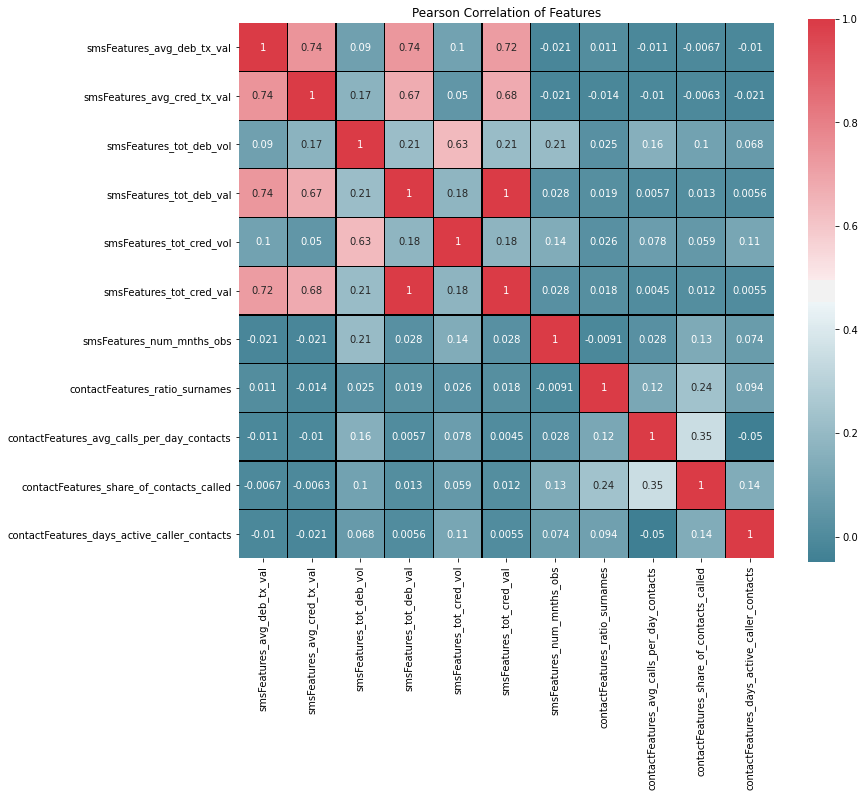

In [13]:
f, ax = plt.subplots(figsize=(12,10))
plt.title('Pearson Correlation of Features')
sns.heatmap(numeric_df.iloc[:,33:44].astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax, linecolor='black', annot=True);

#### Scale the numeric dataframe

In [14]:
scaled_df = StandardScaler().fit_transform(numeric_df)

In [15]:
#Put the numpy array into a dataframe
standard_df = pd.DataFrame(scaled_df, columns = numeric_df.columns)
standard_df.head()

,next_loan_number,Income,demofeatures_net_income_band,demofeatures_appweek,demofeatures_age_at_application_yrs,demofeatures_num_children,smsFeatures_minmaxdebit_tot,smsFeatures_mixmaxcredit_tot,smsFeatures_minbal_tot,smsFeatures_pers_sms_snt_flag,smsFeatures_pers_sms_rec_flag,smsFeatures_arrears_flag,smsFeatures_isp_flag,smsFeatures_sattv_flag,smsFeatures_avg_mly_airtimecredit_val,smsFeatures_avg_airtimecredit_tx_val,smsFeatures_tot_airtimecredit_vol,smsFeatures_tot_airtimecredit_val,smsFeatures_avg_mly_uber_val,smsFeatures_avg_uber_tx_val,smsFeatures_tot_uber_vol,smsFeatures_tot_uber_val,smsFeatures_avg_mly_gamble_val,smsFeatures_avg_gamble_tx_val,smsFeatures_tot_gamble_vol,smsFeatures_tot_gamble_val,smsFeatures_loans_prev2mnths,smsFeatures_loan_pmnts,smsFeatures_val_loans,smsFeatures_avg_sal,smsFeatures_debit_credit_ratio,smsFeatures_avg_mly_deb_val,smsFeatures_avg_mly_cred_val,smsFeatures_avg_deb_tx_val,smsFeatures_avg_cred_tx_val,smsFeatures_tot_deb_vol,smsFeatures_tot_deb_val,smsFeatures_tot_cred_vol,smsFeatures_tot_cred_val,smsFeatures_num_mnths_obs,contactFeatures_ratio_surnames,contactFeatures_avg_calls_per_day_contacts,contactFeatures_share_of_contacts_called,contactFeatures_days_active_caller_contacts,contactFeatures_days_since_last_call_contacts,contactFeatures_days_since_first_call_contacts,contactFeatures_no_contacts_called,contactFeatures_calls_volume_contacts,contactFeatures_most_called_contact_call_volume,contactFeatures_no_contacts,callFeatures_dur_01_miss,callFeatures_dur_02_miss,callFeatures_dur_03_miss,callFeatures_dur_04_miss,callFeatures_dur_05_miss,callFeatures_dur_06_miss,callFeatures_dur_07_miss,callFeatures_dur_08_miss,callFeatures_dur_09_miss,callFeatures_dur_10_miss,callFeatures_dur_11_miss,callFeatures_dur_12_miss,callFeatures_dur_13_miss,callFeatures_dur_14_miss,callFeatures_dur_15_miss,callFeatures_dur_16_miss,callFeatures_dur_17_miss,callFeatures_dur_18_miss,callFeatures_dur_19_miss,callFeatures_dur_20_miss,callFeatures_dur_21_miss,callFeatures_dur_22_miss,callFeatures_dur_23_miss,callFeatures_01_miss,callFeatures_02_miss,callFeatures_03_miss,callFeatures_04_miss,callFeatures_05_miss,callFeatures_06_miss,callFeatures_07_miss,callFeatures_08_miss,callFeatures_09_miss,callFeatures_10_miss,callFeatures_11_miss,callFeatures_12_miss,callFeatures_13_miss,callFeatures_14_miss,callFeatures_15_miss,callFeatures_16_miss,callFeatures_17_miss,callFeatures_18_miss,callFeatures_19_miss,callFeatures_20_miss,callFeatures_21_miss,callFeatures_22_miss,callFeatures_23_miss,callFeatures_dur_01_out,callFeatures_dur_02_out,callFeatures_dur_03_out,callFeatures_dur_04_out,callFeatures_dur_05_out,callFeatures_dur_06_out,callFeatures_dur_07_out,callFeatures_dur_08_out,callFeatures_dur_09_out,callFeatures_dur_10_out,callFeatures_dur_11_out,callFeatures_dur_12_out,callFeatures_dur_13_out,callFeatures_dur_14_out,callFeatures_dur_15_out,callFeatures_dur_16_out,callFeatures_dur_17_out,callFeatures_dur_18_out,callFeatures_dur_19_out,callFeatures_dur_20_out,callFeatures_dur_21_out,callFeatures_dur_22_out,callFeatures_dur_23_out,callFeatures_01_out,callFeatures_02_out,callFeatures_03_out,callFeatures_04_out,callFeatures_05_out,callFeatures_06_out,callFeatures_07_out,callFeatures_08_out,callFeatures_09_out,callFeatures_10_out,callFeatures_11_out,callFeatures_12_out,callFeatures_13_out,callFeatures_14_out,callFeatures_15_out,callFeatures_16_out,callFeatures_17_out,callFeatures_18_out,callFeatures_19_out,callFeatures_20_out,callFeatures_21_out,callFeatures_22_out,callFeatures_23_out,callFeatures_dur_01_in,callFeatures_dur_02_in,callFeatures_dur_03_in,callFeatures_dur_04_in,callFeatures_dur_05_in,callFeatures_dur_06_in,callFeatures_dur_07_in,callFeatures_dur_08_in,callFeatures_dur_09_in,callFeatures_dur_10_in,callFeatures_dur_11_in,callFeatures_dur_12_in,callFeatures_dur_13_in,callFeatures_dur_14_in,callFeatures_dur_15_in,callFeatures_dur_16_in,callFeatures_dur_17_in,callFeatures_dur_18_in,callFeatures_dur_19_in,callFeatures_dur_20_

#### Perform a PCA reduction on the numeric dataframe (Only include the first 5 principal components)
- Store the results in a pandas dataframe. 
- Print the total variance explained by the first 5 principal components.

In [16]:
# Create PCA
pca = PCA(n_components=5, random_state=42)

# fit the data to the model
pca_df = pca.fit_transform(scaled_df)

pca_df.shape

(11993, 5)

In [17]:
# create dataframe containing principal components
principal_cols = ['PC1','PC2', 'PC3', 'PC4', 'PC5']
principal_data = pd.DataFrame(data = pca_df, columns = principal_cols)

# display top 5 principal components
principal_data.head()

,PC1,PC2,PC3,PC4,PC5
0,4.221731,-2.270807,0.763839,-1.596560,4.226436
1,13.461898,-3.655708,-2.136465,-0.890075,-0.204340
2,5.898804,-2.348843,0.101385,0.483914,0.256961
3,-1.883685,1.377413,-0.203857,3.302750,0.287011
4,2.635386,1.728570,0.545219,-2.890721,-0.892753


In [18]:
# Print the total variance explained by the first 5 principal components 
pca.explained_variance_ratio_

array([0.35686693, 0.09457427, 0.03848197, 0.03396488, 0.02778274])

In [19]:
# Print the sum of the explained variance ratio
pca.explained_variance_ratio_.sum()

0.5516707847627164

#### Use Sklearn’s KMeans  to cluster the numeric PCA dataframe into 3 clusters and plot the clusters.

In [20]:
# declare a Kmeans instance with 3 classes
model = KMeans(n_clusters=3, random_state=42)

# fit the data 
clusters = model.fit_predict(pca_df)

clusters

array([0, 2, 0, ..., 0, 0, 0])

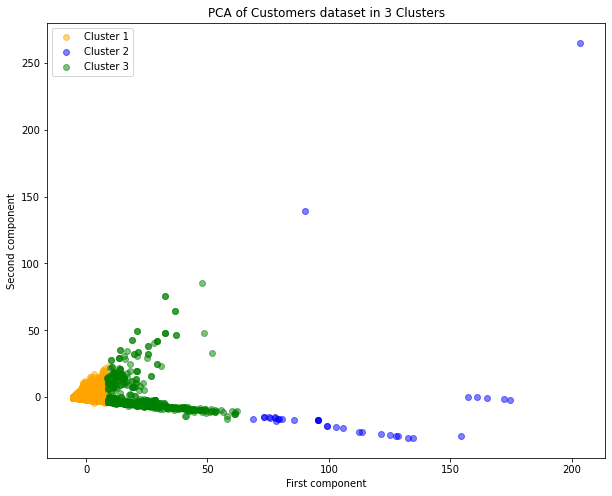

In [21]:
plt.figure(figsize = (10,8))

plt.scatter(pca_df[clusters == 0, 0], pca_df[clusters == 0, 1], alpha=.5, 
            color = 'orange', label='Cluster 1')

plt.scatter(pca_df[clusters == 1, 0], pca_df[clusters == 1, 1], alpha=.5, 
            color = 'blue', label='Cluster 2')

plt.scatter(pca_df[clusters == 2, 0], pca_df[clusters == 2, 1], alpha=.5, 
            color = 'green', label='Cluster 3')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('PCA of Customers dataset in 3 Clusters');

C:\Users\user\Anaconda2\envs\py35\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\user\Anaconda2\envs\py35\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\user\Anaconda2\envs\py35\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\user\Anaconda2\envs\py35\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\user\Anaconda2\envs\py35\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\user\Ana

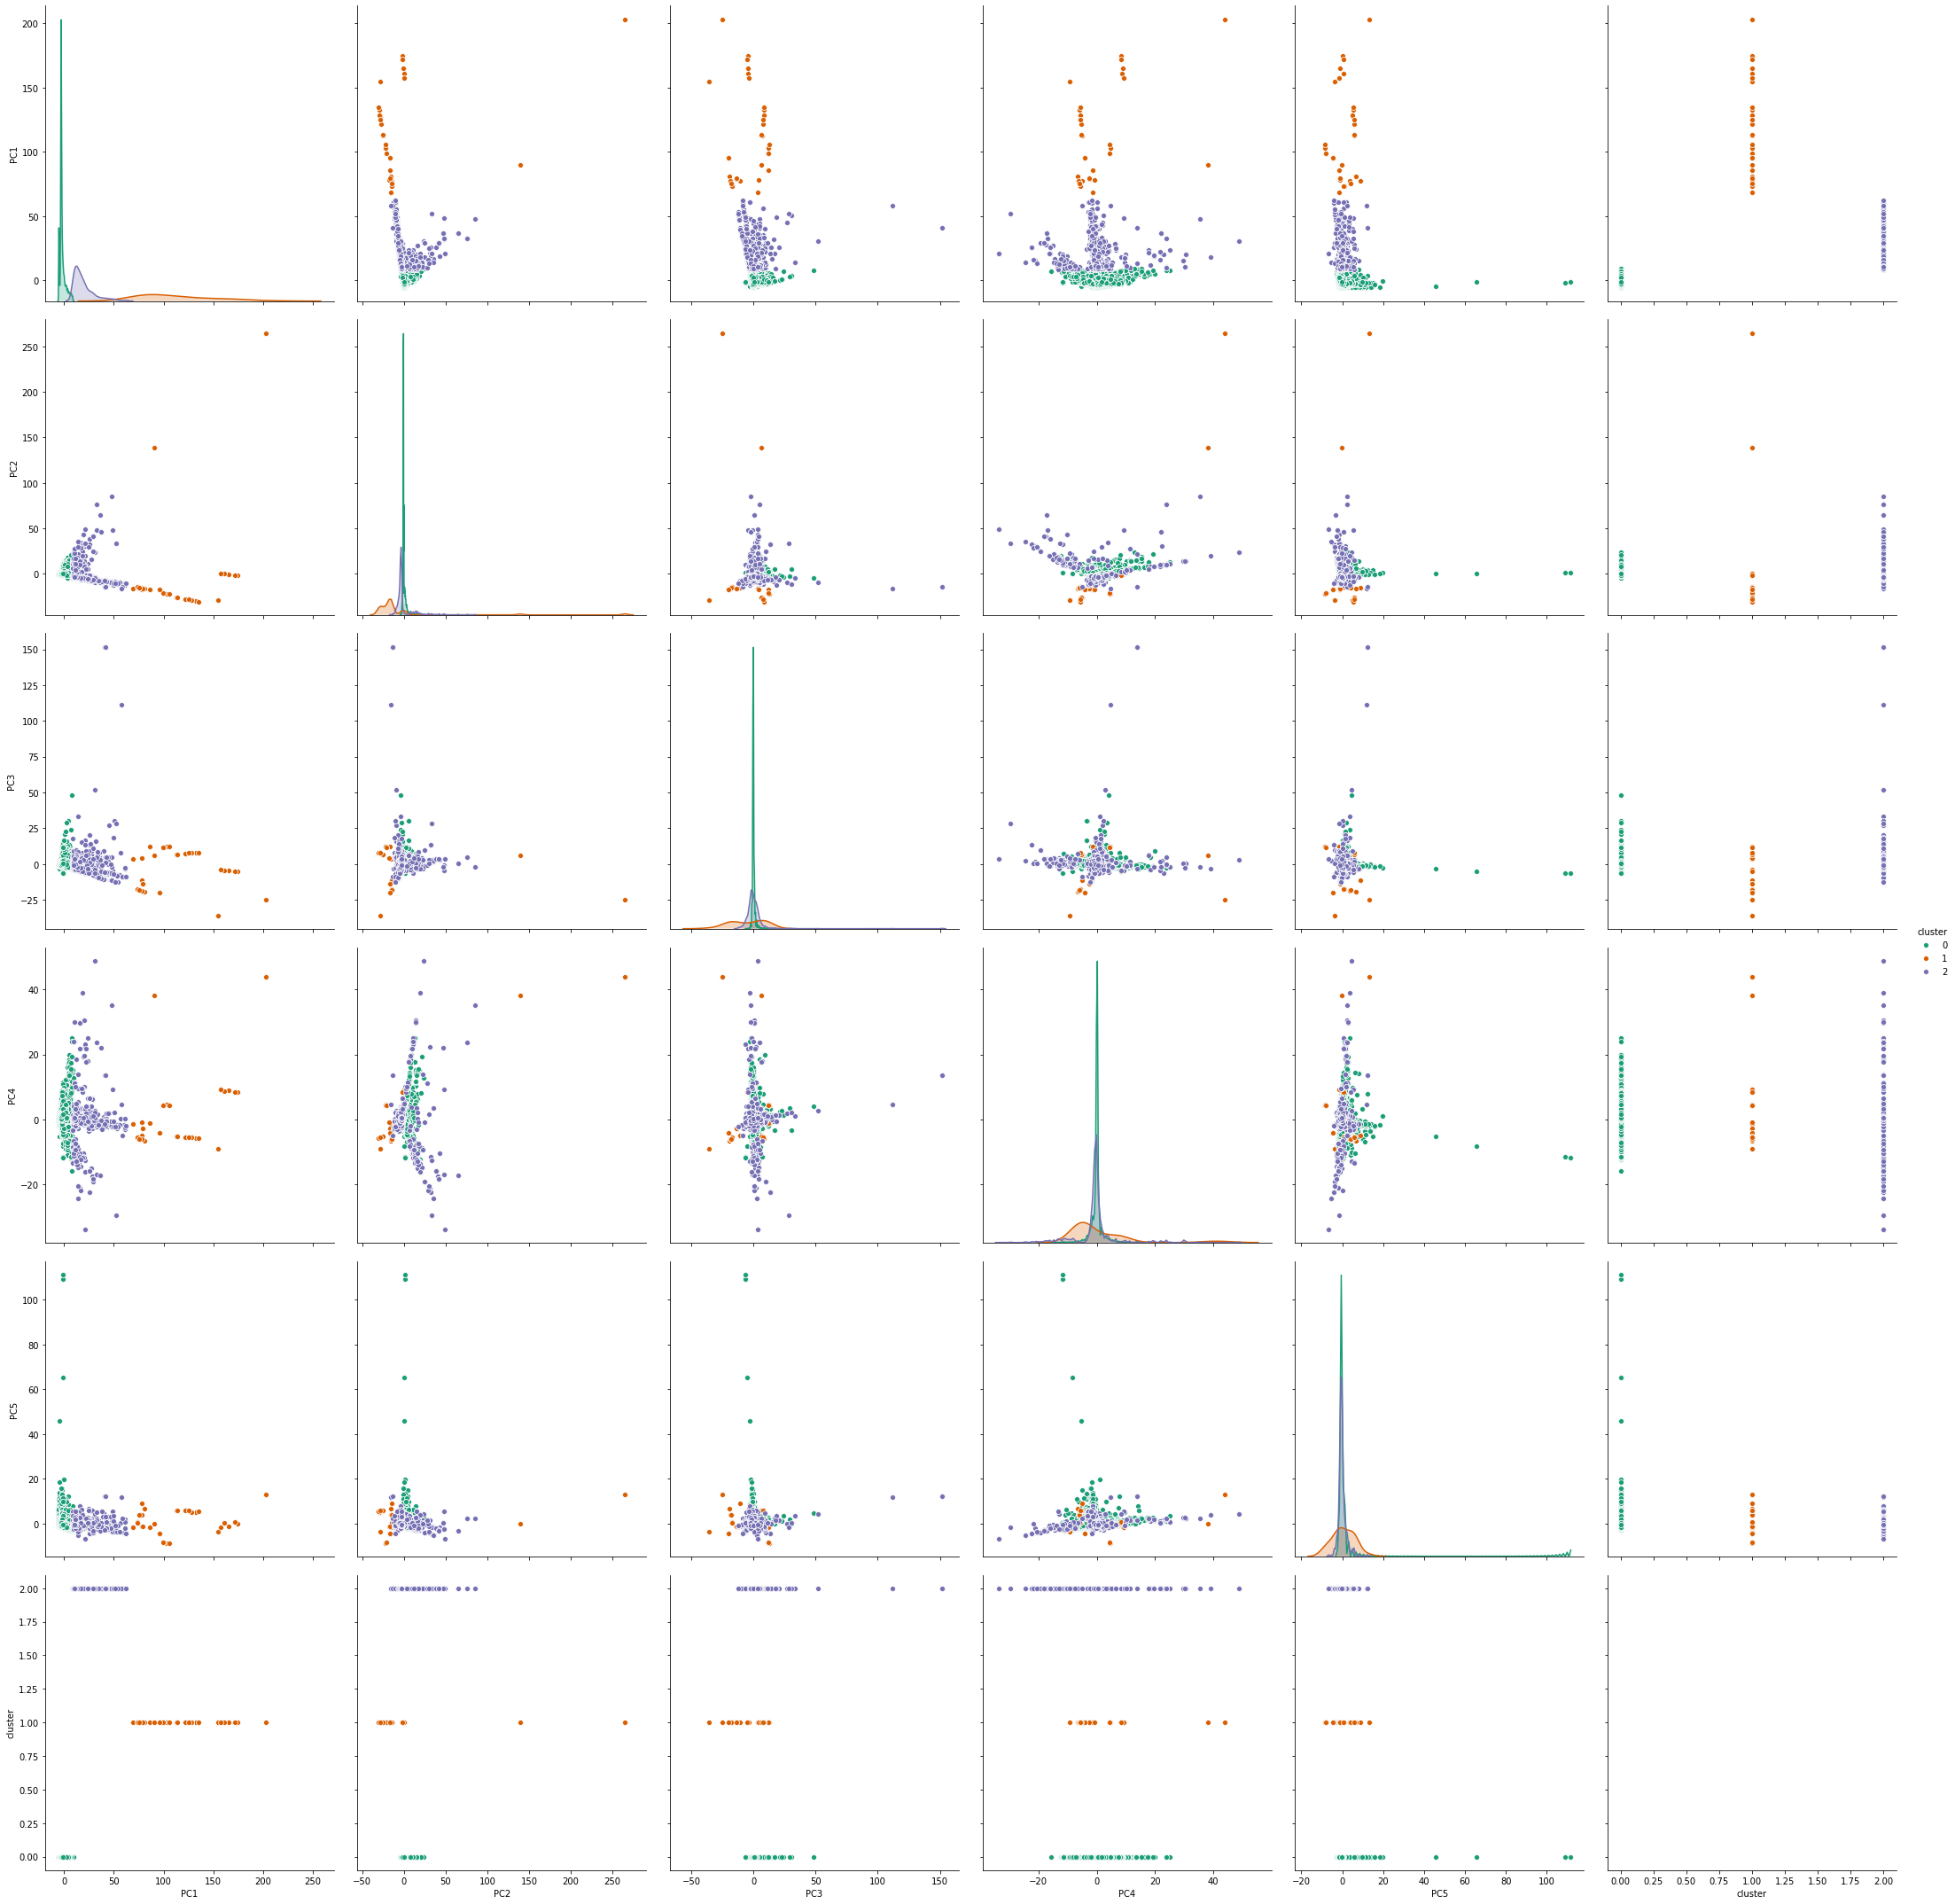

In [22]:
# Assign clusters to a new column 'cluster'
principal_data['cluster'] = clusters

# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(principal_data, hue='cluster', palette= 'Dark2', diag_kind='kde',size=5);

#### Reconnect final clusters of each observation to the original dataframe

In [23]:
# Drop Unnamed: 0from the oriiginal df
final_df = data.drop('Unnamed: 0', axis = 1)
pca_clusters_df = pd.concat([final_df, principal_data.cluster], axis = 1)

### Exploratory Data Analysis

Text(0.5, 1.0, 'Mean Income grouped by Clusters')

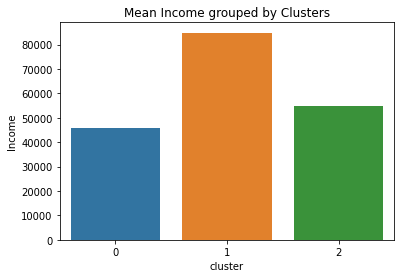

In [24]:
#Plot of mean income by clusters
grouping = pca_clusters_df.groupby('cluster')
data_mean = grouping['Income'].mean().reset_index()

sns.barplot(x='cluster', y='Income', data=data_mean)
plt.title('Mean Income grouped by Clusters')

Text(0.5, 1.0, 'Maximum Income grouped by Clusters')

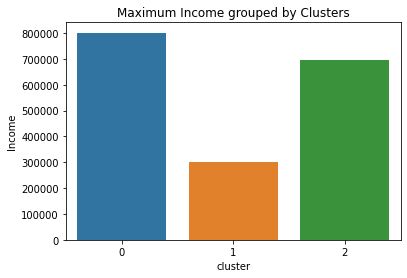

In [25]:
#Maximum income by cluster
data_max = grouping['Income'].max().reset_index()

sns.barplot(x='cluster', y='Income', data=data_max)
plt.title('Maximum Income grouped by Clusters')

Text(0.5, 1.0, 'Minimum Income grouped by Clusters')

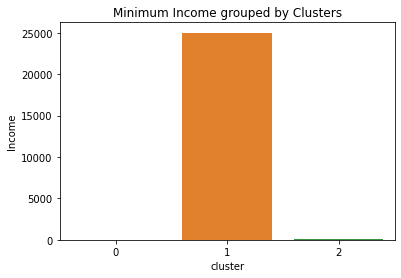

In [26]:
#Minimum income by cluster
data_min = grouping['Income'].min().reset_index()

sns.barplot(x='cluster', y='Income', data=data_min)
plt.title('Minimum Income grouped by Clusters')

Text(0.5, 1.0, 'Mean Demofeatures Net Income Band grouped by Clusters')

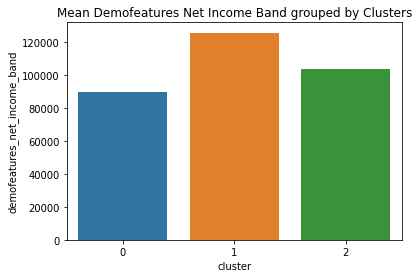

In [27]:
#Mean Demofeatures Net Income Band by cluster
demo_income_mean = grouping['demofeatures_net_income_band'].mean().reset_index()

sns.barplot(x='cluster', y='demofeatures_net_income_band', data=demo_income_mean)
plt.title('Mean Demofeatures Net Income Band grouped by Clusters')

Text(0.5, 1.0, 'Mean Income grouped by Clusters and Purpose of Loan')

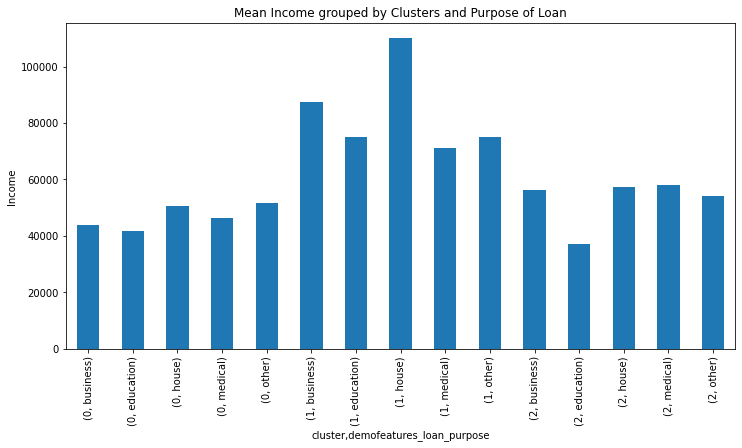

In [28]:
#Mean Income grouped by Clusters and Purpose of Loan
fig, ax = plt.subplots(figsize=(12,6))
pca_clusters_df.groupby(['cluster','demofeatures_loan_purpose']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Mean Income grouped by Clusters and Purpose of Loan')

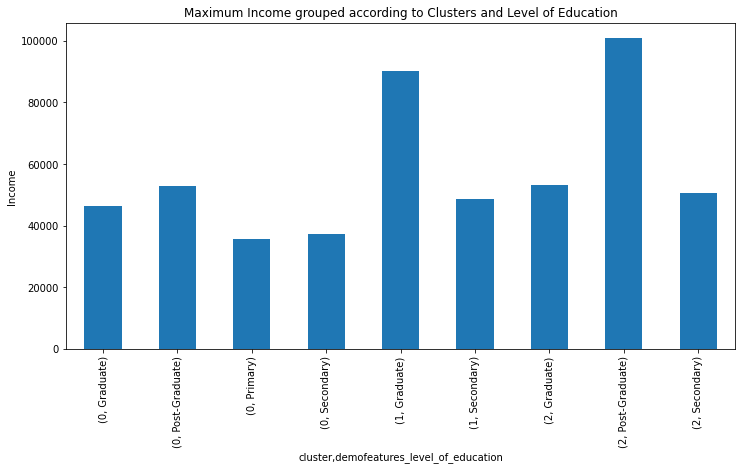

In [30]:
# Mean Income grouped by Clusters and Level of Education
fig, ax = plt.subplots(figsize=(12,6))
pca_clusters_df.groupby(['cluster','demofeatures_level_of_education']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Maximum Income grouped according to Clusters and Level of Education');

Text(0.5, 1.0, 'Mean Income grouped by Clusters and Marital Status')

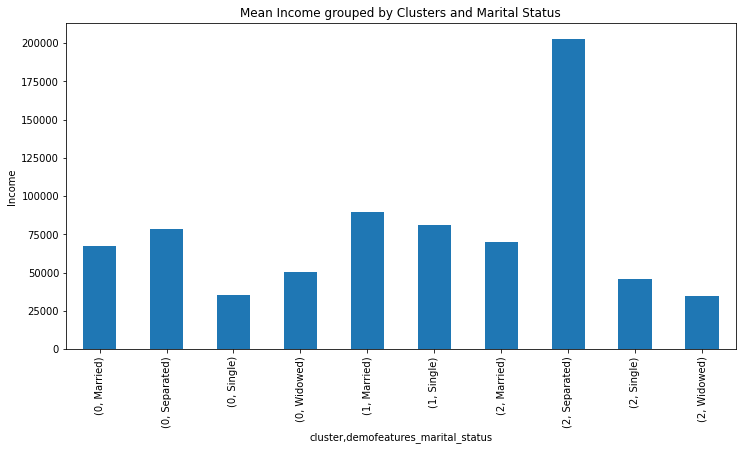

In [31]:
#Mean Income grouped by Clusters and Marital Status
fig, ax = plt.subplots(figsize=(12,6))
pca_clusters_df.groupby(['cluster','demofeatures_marital_status']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Mean Income grouped by Clusters and Marital Status')

Text(0.5, 1.0, 'Mean Income grouped by Clusters and Residential Status')

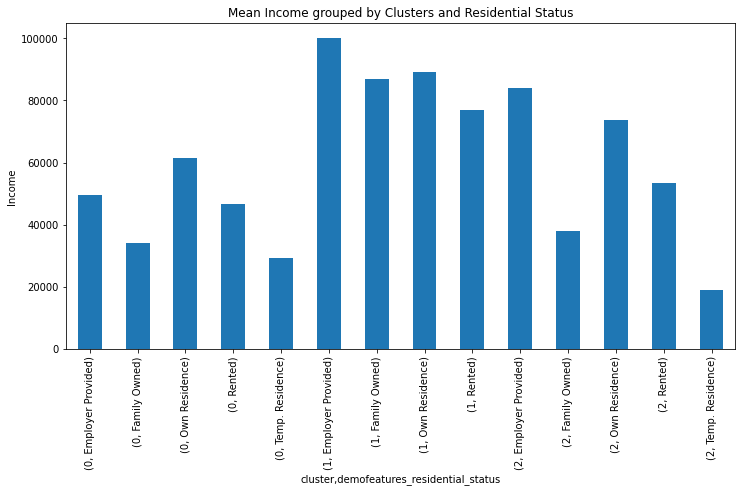

In [32]:
#Mean Income grouped by Clusters and residential Status
fig, ax = plt.subplots(figsize=(12,6))
pca_clusters_df.groupby(['cluster','demofeatures_residential_status']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Mean Income grouped by Clusters and Residential Status')

Text(0.5, 1.0, 'Mean Income grouped by Clusters and Client Employment Status')

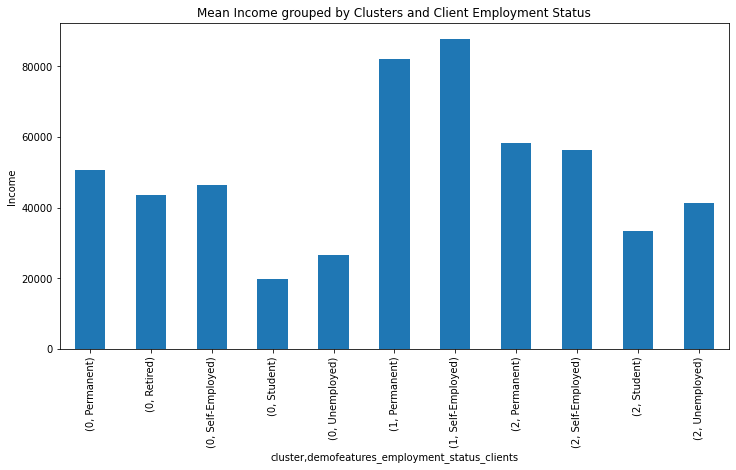

In [33]:
#Mean Income grouped by Clusters and Client Employment Status
fig, ax = plt.subplots(figsize=(12,6))
pca_clusters_df.groupby(['cluster','demofeatures_employment_status_clients']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Mean Income grouped by Clusters and Client Employment Status')

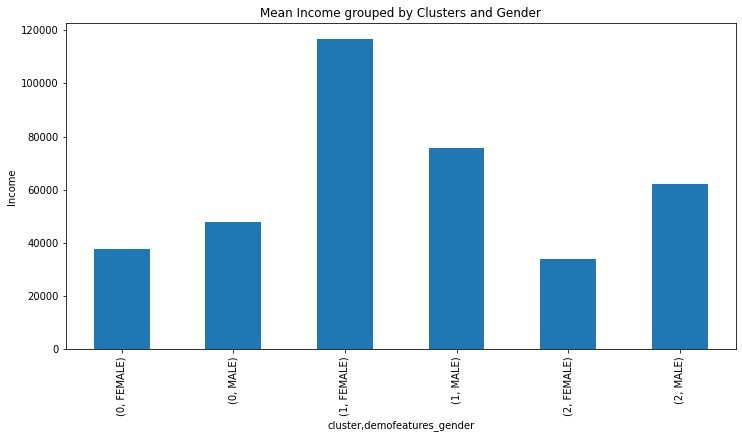

In [34]:
#Mean Income grouped by Clusters and Gender
fig, ax = plt.subplots(figsize=(12,6))
pca_clusters_df.groupby(['cluster','demofeatures_gender']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Mean Income grouped by Clusters and Gender');

Text(0.5, 1.0, 'Mean Income grouped by Clusters and Number of Children')

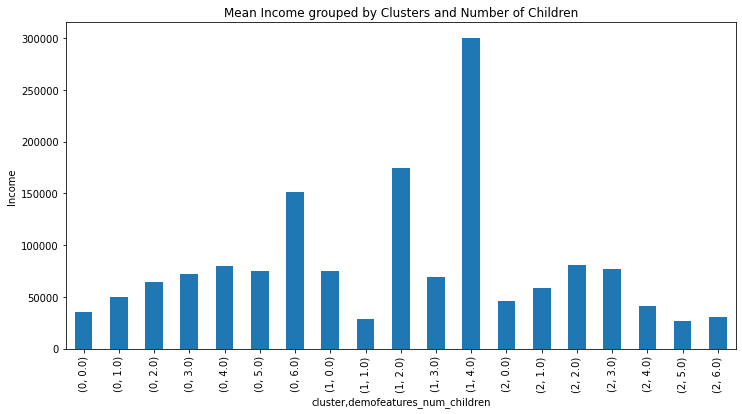

In [35]:
#Mean Income grouped by Clusters and Number of Children
fig, ax = plt.subplots(figsize=(12,6))
pca_clusters_df.groupby(['cluster','demofeatures_num_children']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Mean Income grouped by Clusters and Number of Children')

Text(0.5, 1.0, 'Mean Income grouped by Clusters and State of Residence')

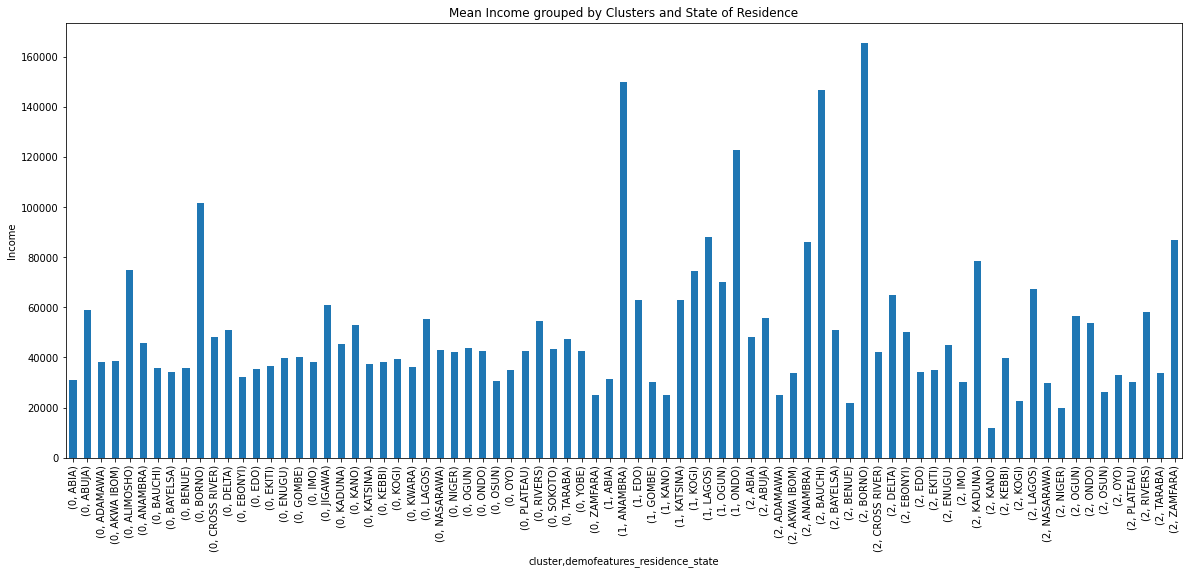

In [36]:
#Mean Income grouped by Clusters and State of Residence
fig, ax = plt.subplots(figsize=(20,8))
pca_clusters_df.groupby(['cluster','demofeatures_residence_state']).mean()['Income'].plot(ax=ax, kind='bar')

plt.ylabel('Income')
plt.title('Mean Income grouped by Clusters and State of Residence')

In [38]:
# Clusters Grouped by Genders
unique_customers = grouping['demofeatures_gender'].apply(pd.Series.value_counts).reset_index()
unique_customers

,cluster,level_1,demofeatures_gender
0,0,MALE,9009
1,0,FEMALE,2081
2,1,MALE,28
3,1,FEMALE,8
4,2,MALE,641
5,2,FEMALE,224


In [39]:
# Mean, Minimum and Maximum of features that might be important, aswell as their count
grouping.agg({
    'Income': ['mean','min','max'],
    'demofeatures_net_income_band': ['mean','min','max'],
    'demofeatures_num_children': ['mean','min','max'],
    'demofeatures_net_income_band': ['mean','min','max'],
    'predictedIncome': ['mean','min','max'],
    'demofeatures_age_at_application_yrs': ['mean','min','max', 'count']
  }).round(1)

Income                    demofeatures_net_income_band           \
            mean      min       max                         mean      min   
cluster                                                                     
0        45874.0     18.5  801776.7                      89461.2      0.0   
1        84844.6  25000.0  300000.0                     125694.4  25000.0   
2        54904.4     74.2  696986.0                     103959.5  25000.0   

                  demofeatures_num_children           predictedIncome       \
              max                      mean  min  max            mean  min   
cluster                                                                      
0        750000.0                       0.8  0.0  6.0         37594.7 -1.0   
1        500000.0                       1.2  0.0  4.0         57441.2 -1.0   
2        750000.0                       0.9  0.0  6.0         43168.3 -1.0   

                  demofeatures_age_at_application_yrs                      
              max                                mean   min    max  count  
cluster                                                                    
0        277381.2                                29.5  17.0  147.0  11090  
1        181413.6                                31.5  21.0   45.0     36  
2        219053.9                                31.9  19.0   57.0    865